In [81]:
""" packages """
from google.colab import drive
import os 
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics 
import time 
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 2
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
  
""" mount, read data """
def load_data():
  # mount
  drive.mount("/content/drive")
  # set directory 
  if os.getcwd() != "/content/drive/My Drive/Pusula/":
    os.chdir("/content/drive/My Drive/Pusula/")
  # read data
  df = pd.read_csv("features4_5m_all.csv")
  return df 

""" train, test split """
def train_test_split(df):
  # drop time for scaler 
  df.drop(['TimeStamp_x'], axis = 1, inplace = True) 
  # split train and test data 
  limit_train = int(df.shape[0]*0.75)
  train = df.iloc[0:limit_train:,]
  test =  df.iloc[limit_train::,]
  X_train = train.loc[:,:'ALM_Mainau2_HDVacValveFeed_Scale_PDP_y.1'].values
  y_train = train['Label'].values
  X_test = test.loc[:,:'ALM_Mainau2_HDVacValveFeed_Scale_PDP_y.1'].values
  y_test = test['Label'].values
  return X_train, y_train, X_test, y_test

""" preprocessing """
def pre_process(X_train):
  # scale and normalize 
  X_train_scaled = StandardScaler().fit_transform(X_train)
  X_train_normalized = normalize(X_train_scaled)
  # reduce dimensionality 
  n_components = 5
  pca = PCA(n_components = n_components) 
  X_train_principal = pca.fit_transform(X_train_normalized) 
  # preprocessed data 
  X_train_principal = pd.DataFrame(X_train_principal, columns = ["P" + str(i) for i in range(1, n_components + 1)])
  return X_train_principal, n_components 

""" identify components that account for approx. 85% of data """
def plot_variation(X_train_principal, n_components):
  cov_mat = np.cov(X_train_principal.T)
  eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
  tot = sum(eigen_vals)
  var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
  cum_var_exp = np.cumsum(var_exp)
  fig, ax = plt.subplots(figsize = (5,5))
  ax.bar(range(1, n_components + 1), var_exp, alpha=0.75, align='center', label='individual explained variance')
  ax.step(range(1, n_components + 1), cum_var_exp, where='mid', label='cumulative explained variance', color = "green")
  plt.ylim(0, 1.1)
  plt.xlabel('Principal components')
  plt.ylabel('Explained variance ratio')
  plt.legend(loc='best')
  plt.show()
  # return the number of pca components that make up at least 85% of data 
  # refer to the graph nonetheless
  for i in range(len(cum_var_exp)):
    if cum_var_exp[i] >= 0.85:
      return i

""" DBSCAN results plot, cluster visualization """
def plot_dbscan(X_train_principal):
  c = np.random.randint(0, 2, size=X_train_principal.shape[0])
  fig, ax = plt.subplots(figsize = (5,5))
  scatter = ax.scatter(X_train_principal['P1'], X_train_principal['P2'], c = c) 
  legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
  ax.add_artist(legend)
  plt.show()

""" 3D PCA plot """
def plot_3D(X_train_principal):
  # initialize figure and 3d projection for the PC3 data
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  # assign x,y,z coordinates from PC1, PC2 & PC3
  xs = X_train_principal["P1"]
  ys = X_train_principal["P2"]
  zs = X_train_principal["P3"]
  # initialize scatter plot and label axes
  ax.scatter(xs, ys, zs, alpha=0.75, c='green')
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.set_zlabel('PC3')
  plt.show()

""" cluster performance """
def cluster_benchmark(X_train_principal, y_train, labels):
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)
  print('\nEstimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)
  print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, labels))
  print("Completeness: %0.3f" % metrics.completeness_score(y_train, labels))
  print("V-measure: %0.3f" % metrics.v_measure_score(y_train, labels))
  print("Adjusted Rand Index: %0.3f"
        % metrics.adjusted_rand_score(y_train, labels))
  print("Adjusted Mutual Information: %0.3f"
        % metrics.adjusted_mutual_info_score(y_train, labels))
  print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X_train_principal, labels))
  
def elbow(X_train_principal):
  inertia = []
  for i in range(1,11):
    km = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    km.fit(X_train_principal)
    inertia.append(km.inertia_)
  fig, ax = plt.subplots()
  ax.plot(range(1, 11, 1), inertia, marker = "o", alpha = 0.75)
  ax.set_xlabel("# Clusters")
  ax.set_ylabel("Sum of Squared Errors")
  ax.set_title("KMeans After Dimensionality Reduction", loc = "center")
  plt.show()

def kmeans(X_train_principal, y_train):
  km = KMeans(n_clusters = 3, init = "k-means++", random_state=42)
  predictions = km.fit_predict(X_train_principal)
  print(f"Size of cluster 1: {predictions[predictions == 0].shape[0]}")
  print(f"Size of cluster 2: {predictions[predictions == 1].shape[0]}")
  print(f"Size of cluster 3: {predictions[predictions == 2].shape[0]}")
  cluster_benchmark(X_train_principal, y_train, km.labels_)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

# Total Data: 85305
# Features: 66

# X_train: 63978
# y_train: 63978

# X_test: 21327
# y_test: 21327



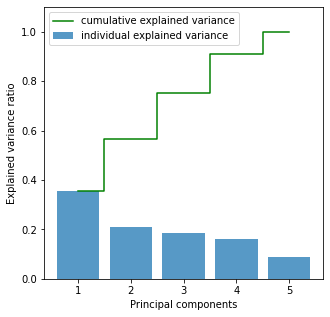


3 components explain at least 85% of data.


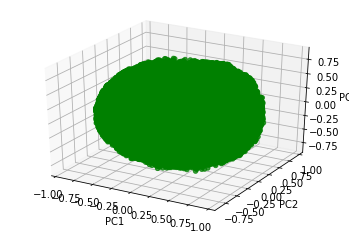

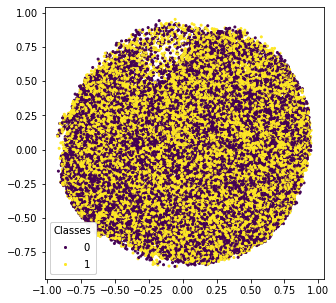

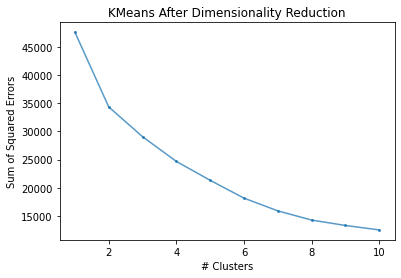

Size of cluster 1: 24308
Size of cluster 2: 26709
Size of cluster 3: 12961

Estimated number of clusters: 3
Estimated number of noise points: 0
Homogeneity: 0.015
Completeness: 0.001
V-measure: 0.002
Adjusted Rand Index: -0.000
Adjusted Mutual Information: 0.002
Silhouette Coefficient: 0.251

Script time: 101.51 sec


In [82]:
def main(): 
  start_time = time.time()
  # load data 
  df = load_data()
  # row, feature count
  print(f"\n# Total Data: {df.shape[0]}\n# Features: {df.shape[1]}\n")
  # split train and test data
  X_train, y_train, X_test, y_test = train_test_split(df)
  del df 
  # shape and size of train and test data 
  print("# X_train: {X_train_size}\n# y_train: {y_train_size}\n".format(X_train_size = X_train.shape[0], y_train_size = y_train.shape[0]))
  print("# X_test: {X_test_size}\n# y_test: {y_test_size}\n".format(X_test_size = X_test.shape[0], y_test_size = y_test.shape[0]))
  # check train and test dimension
  assert(X_test.shape[0] == y_test.shape[0])
  assert(X_train.shape[0] == y_train.shape[0])
  # get preprocessed, reduced data 
  X_train_principal, n_components = pre_process(X_train)
  start_time = time.time()
  # build the algorithm
  db = DBSCAN(eps = 0.03, min_samples = 10).fit(X_train_principal) 
  labels = db.labels_ 
  # visualize components in PCA analysis
  n_components = plot_variation(X_train_principal, n_components)
  print("\n{n_components} components explain at least 85% of data.".format(n_components = n_components))
  if n_components >= 3:
    plot_3D(X_train_principal)
  # plot clusters 
  plot_dbscan(X_train_principal)
  # benchmark 
  # cluster_benchmark(X_train_principal, y_train, labels)
  # generate an elbow curve 
  elbow(X_train_principal)
  kmeans(X_train_principal, y_train)
  # script end 
  print(f"\nScript time: {round(time.time() - start_time, 2)} sec")

if __name__ == "__main__":
  main()